# LQB385 Bioinformatics Workshop 3 - Analysis Notebook

**Run the code cell below ⤵️ first to initialise the project!**

In [ ]:
# Project startup (always upload analysed_GSE63310.RData and run this cell when notebook is first opened)
# NOTE TO USER ---------------------------
# Do not modify code in this cell!
# Else it won't work!

# Install packages
install.packages(
  packages = c(
    "colorspace",
    "corrplot",
    "EnhancedVolcano",
    "formattable",
    "ggpubr",
    "ggsignif",
    "knitr",
    "limma",
    "magrittr",
    "metan",
    "nghiaagentrutils",
    "PCAtools",
    "rlang",
    "tibble",
    "tidyverse"
  ),
  repos = c(
    "https://repo.r-wasm.org",
    "https://bioc.r-universe.dev",
    "https://cran.r-universe.dev",
    "https://dmuellner.r-universe.dev",
    "https://nepem-ufsc.r-universe.dev",
    "https://nghiaagent.r-universe.dev",
    "https://renkun-ken.r-universe.dev",
    "https://rstudio.r-universe.dev",
    "https://r-lib.r-universe.dev",
    "https://tidyverse.r-universe.dev"
  )
)

# Import packages
library("colorspace")
library("corrplot")
library("EnhancedVolcano")
library("formattable")
library("ggpubr")
library("ggsignif")
library("knitr")
library("limma")
library("magrittr")
library("metan")
library("nghiaagentrutils")
library("PCAtools")
library("rlang")
library("tibble")
library("tidyverse")

# Define functions used in this notebook
symbol_to_entrez <- function(EList, symbols) {
  # This function accepts an EList containing voom-normalised logCPM data
  # a vector of characters representing genes of interest
  # and outputs the corresponding indices.
  # With error catching!
  indices <- which(EList$genes$SYMBOL %in% symbols)

  ## Check: Error if there are fewer ENTREZ IDs than gene symbols (impossible)
  if (length(indices) < length(symbols)) {
    stop(
      "There are fewer gene IDs than there should be. Check your gene symbols!"
    )
  }

  return(indices)
}

voom_to_long <- function(EList, symbols) {
  # This function accepts an EList containing voom-normalised logCPM data;
  # a vector of characters representing gene of interest
  # and outputs a dataframe ready for tidyverse data analysis

  # Get indices of selected genes
  indices <- symbol_to_entrez(EList, symbols)

  # Filter EList for selected indices
  # Rename rownames into gene symbols
  # Then transpose
  # Then convert into dataframe
  # Build 2 cases: if there is one gene, treat extracted data as a vector.
  # If there are multiple, treat extracted data like a df
  if (length(indices) == 1) {
    # Add column for sample_id
    lcpm_selected <- EList$E[indices, ]
    lcpm_selected <- tibble(
      sample_id = names(lcpm_selected),
      logCPM = lcpm_selected
    )

    # Get samplesheet
    # Append expression data
    # Make tidy
    lcpm_output <- EList$targets %>%
      rownames_to_column("sample_id") %>%
      left_join(
        lcpm_selected,
        by = join_by("sample_id" == "sample_id"),
        unmatched = "error"
      )

    # Return data
    return(lcpm_output)
  } else {
    # Add column for sample_id
    lcpm_selected <- EList$E[indices, ] %>%
      set_rownames(symbols) %>%
      t() %>%
      as.data.frame() %>%
      rownames_to_column("sample_id")

    # Get samplesheet
    # Append expression data
    # Make tidy
    lcpm_output <- EList$targets %>%
      rownames_to_column("sample_id") %>%
      left_join(
        lcpm_selected,
        by = join_by("sample_id" == "sample_id"),
        unmatched = "error"
      ) %>%
      pivot_longer(
        cols = symbols,
        names_to = "SYMBOL",
        values_to = "logCPM"
      )

    # Return data
    return(lcpm_output)
  }
}

voom_to_matrix <- function(EList, symbols) {
  # This function accepts an EList containing voom-normalised logCPM data;
  # a vector of characters representing gene of interest
  # and outputs a matrix for correlation heatmaps

  # Get indices of selected genes
  indices <- symbol_to_entrez(EList, symbols)

  # Filter EList for selected indices
  # Rename rownames into gene symbols
  lcpm_selected <- EList$E[indices, ] %>%
    set_rownames(symbols)

  # Return data
  return(lcpm_selected)
}

get_signif_gse <- function(MArrayLM, symbol, contrasts) {
  # This function accepts a contrasted MArrayLM,
  # a character representing the gene of interest
  # a vector of contrasts to extract data from
  # and outputs a vector of adjusted p values.

  out <- map(contrasts, \(contrast) {
    topTable(
      fit = MArrayLM,
      coef = contrast,
      number = Inf,
      sort.by = "none"
    ) %>%
      filter(SYMBOL == symbol) %>%
      .$adj.P.Val
  }) %>%
    unlist() %>%
    stars_pval()

  return(out)
}

format_gene_symbol_gse <- function(symbol) {
  symbol %>%
    str_replace_all("_", " ") %>%
    str_wrap(width = 20, whitespace_only = TRUE)
}

# Load data
load("./analysed_GSE63310.Rdata")

---

# Background

## About the current study  

Populations of multipotent mammary stem cells (Basal), luminal progenitor cells (LP), and mature luminal cells (ML) were extracted from three mice (*Mus musculus, n = 3 per condition, 9 samples in total*) ([Shackleton et al., 2006](https://www.nature.com/articles/nature04372), [Sheridan et al., 2015](https://link.springer.com/article/10.1186/s12885-015-1187-z)). These cells represent the different stages of mammary epithelial tree development, and were subjected to RNA sequencing to determine gene expression changes that may regulate mammary stem cell renewal, proliferation and differentiation.


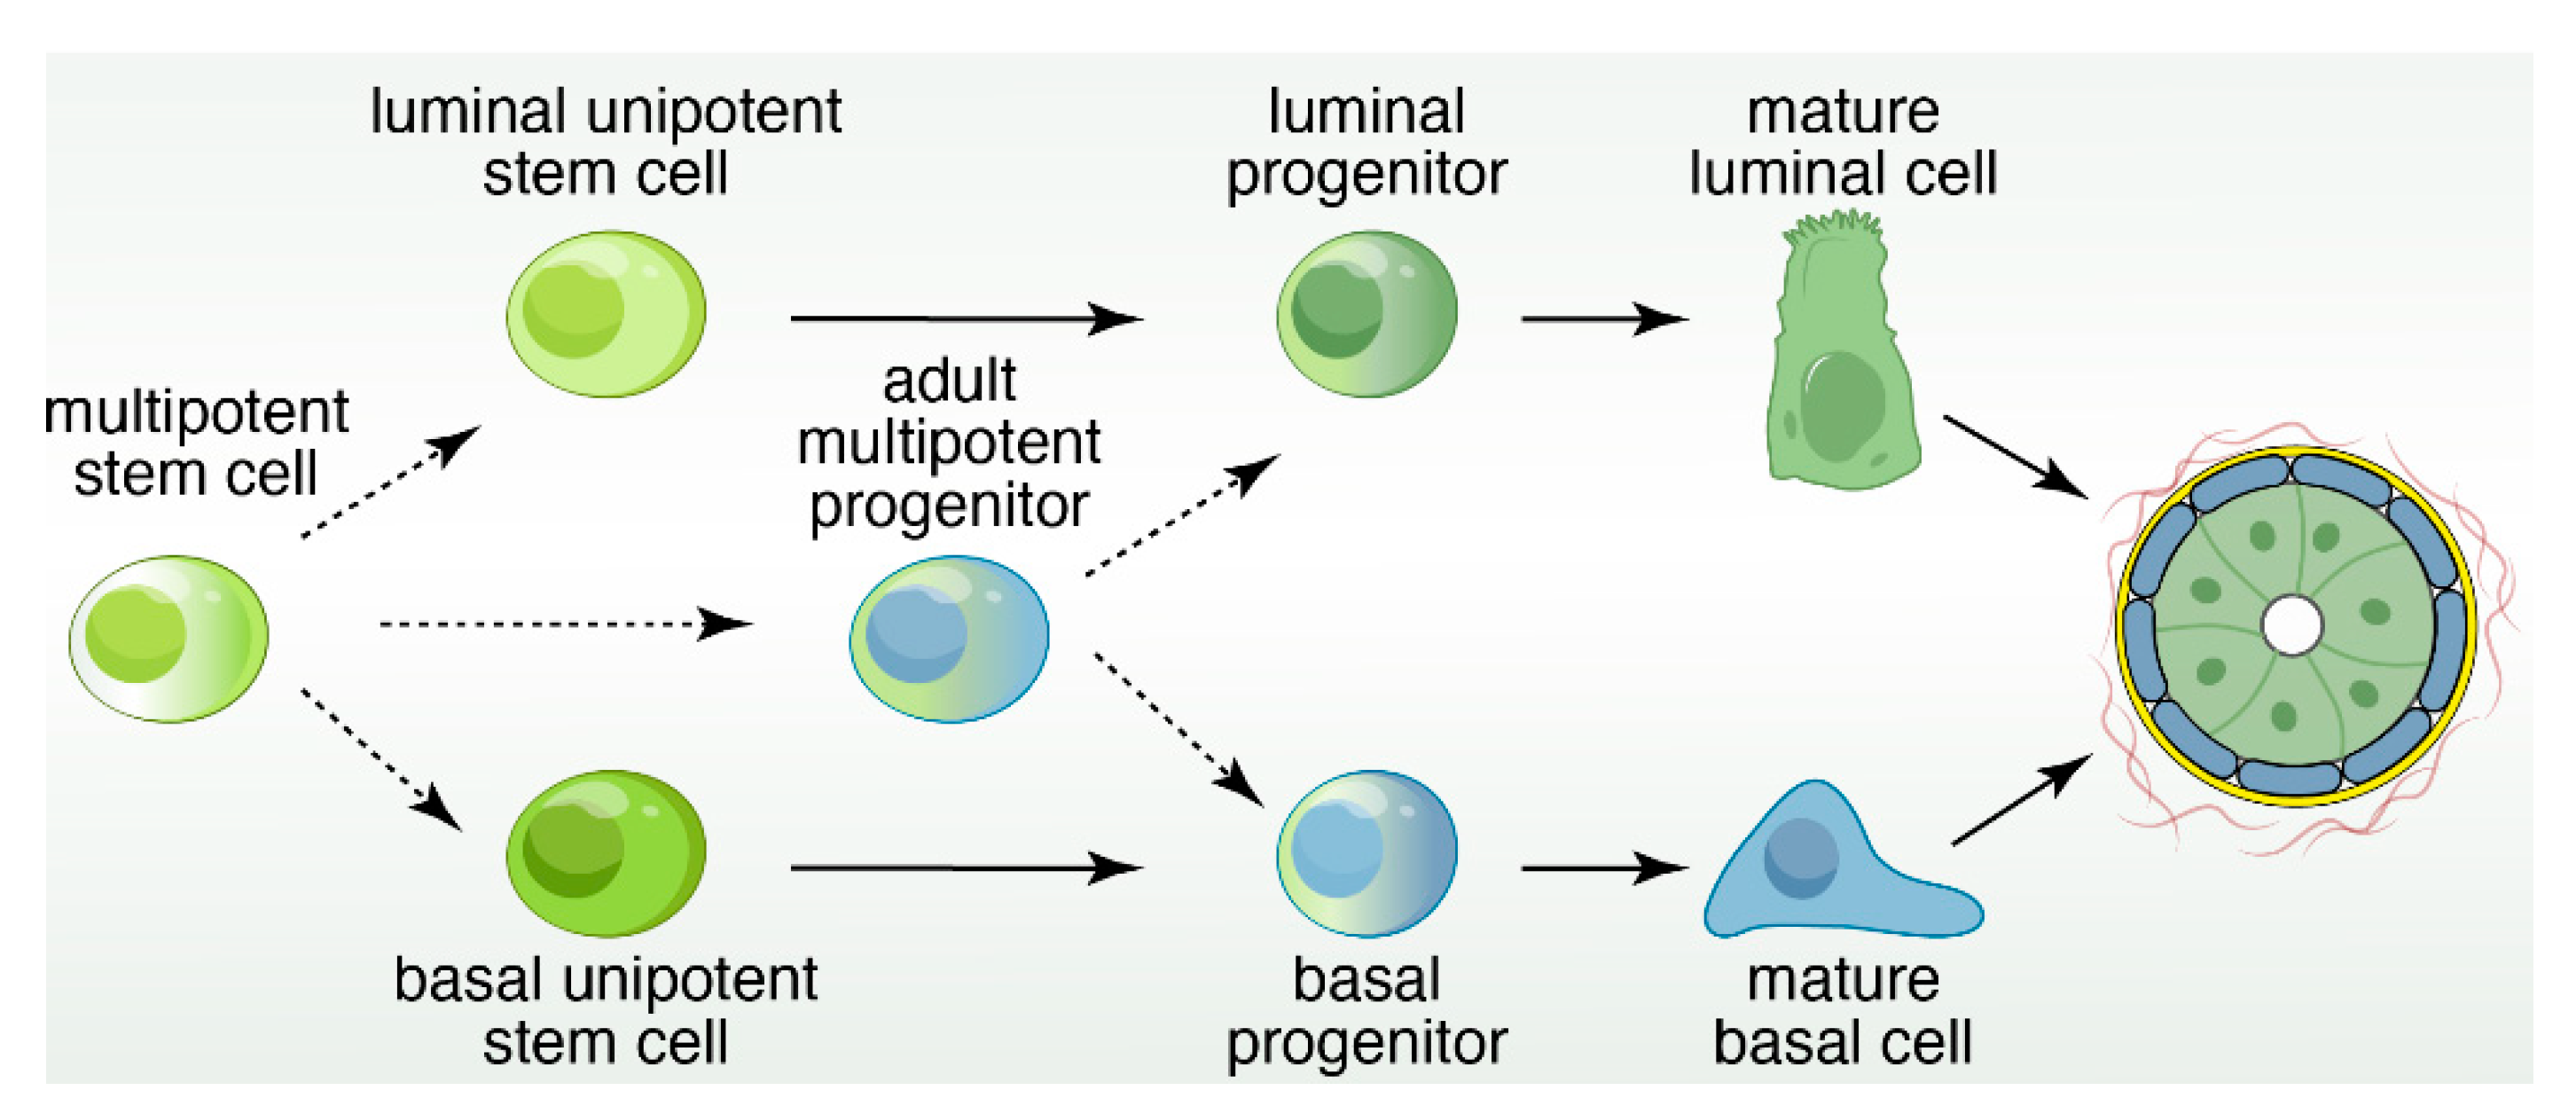
  
**Schematic of the developmental hierarchy in the mammary gland**. From ["Unraveling Heterogeneity in Epithelial Cell Fates of the Mammary Gland and Breast Cancer"](https://www.mdpi.com/2072-6694/11/10/1423). Multipotent mammary stem cells (Basal), luminal progenitors (LP), and mature luminal (ML) cells are explored in the current study.

## About the analysis  

### Differential gene expression  

Sequencing counts was transformed to log-counts per million (logCPM) for statistical analysis. These values behave similarly to qPCR log-gene expression ($\log(2^{-dCt})$) from a statistical perspective.  

Differential gene expression analysis (limma moderated t-test [(Law et al., 2014)](https://link.springer.com/article/10.1186/gb-2014-15-2-r29)) was performed to determine transcriptional changes between Basal, LP, and ML cells. Accordingly, three comparisons were defined:  

- `lp_vs_basal`: Expression differences between LP and Basal cells.
- `ml_vs_basal`: Expression differences between ML and Basal cells.
- `ml_vs_lp`:    Expression differences between ML and LP cells.

In some visualisations included in this notebook, you can replace the `current_contrast` variable with one of the comparisons defined above to display your desired comparison.  

### Gene set analysis  

To determine biological pathways that may regulate mammary stem cell renewal, proliferation and differentiation, gene set analysis was performed against the Molecular Signatures Database mouse-ortholog hallmark (MH) gene set collection.  

The MH collection includes 50 highly-curated gene sets representing various biological processes, with gene symbols converted from human gene symbols to mouse gene symbols.  

To browse these gene sets, go to: [https://www.gsea-msigdb.org/gsea/msigdb/mouse/genesets.jsp?collection=MH](https://www.gsea-msigdb.org/gsea/msigdb/mouse/genesets.jsp?collection=MH)  

To browse the human equivalent sets, go to: [https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=H](https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=H)  

### Pro tips  

- For the best experience, view this notebook in light mode.
- Mouse gene symbols, unlike human gene symbols, are in sentence case (e.g. `Sulf1`, `Actg1`).
- R is case-sensitive; make sure you use the correct case at all times.

---

# Results  

## Analysis of genes of interest  

This section includes code cells for the following analyses:  

- Gene expression histogram
  - Visualisation of expression of one gene.
- Gene expression boxplots
  - Visualisation of expression of one gene across experimental conditions.
- Correlation scatterplot
  - Visualisation of correlation between two selected genes.
- Correlation heatmap
  - Visualisation of correlation between selected genes.

All these analyses use logCPM data.  

### Gene expression histogram  
The following code produces a histogram of gene expression for the selected gene.  

In [ ]:
# Set gene(s) to be plotted
## Remember that Mus Musculus gene names are in Sentence Case
## e.g. Sulf1 Acta1
current_gene <- "Sulf1"

if (length(current_gene) > 1) {
  stop("This plot can only visualise one gene")
}

# Extract gene expression data
lcpm_histogram <- voom_to_long(GSE_logCPM, current_gene)

# Construct histogram
plot_histogram <- lcpm_histogram %>%
  ggplot(aes(x = logCPM)) +
  geom_histogram() +
  theme_minimal() +
  labs(y = "No. of observations") +
  ggtitle(label = format_gene_symbol_gse(current_gene))

# Draw histogram
plot(plot_histogram)


**Histogram of log-expression values for the selected gene.** The x axis (horizontal) represented logCPM values for each tested samples, with higher logCPM values denoting higher gene expression. The y axis (vertical) represented the number of times each expression value was observed.

### Gene expression boxplots  

The following code produces a boxplot of gene expression changes for the selected gene.  

In [ ]:
# Set gene(s) to be plotted
current_gene <- "Sulf1"

if (length(current_gene) > 1) {
  stop("This plot can only handle 1 gene")
}

# Extract gene expression data
lcpm_boxplot <- voom_to_long(GSE_logCPM, current_gene)

# Construct histogram
plot_box <- lcpm_boxplot %>%
  ggplot(aes(x = group, y = logCPM)) +
  geom_boxplot(aes(colour = group), outliers = FALSE) +
  geom_jitter(size = 1.2, stroke = 0.5, alpha = 0.5) +
  geom_signif(
    comparisons = list(
      c("Basal", "LP"),
      c("Basal", "ML"),
      c("LP", "ML")
    ),
    annotation = get_signif_gse(
      GSE_fitted,
      current_gene,
      c("lp_vs_basal", "ml_vs_basal", "ml_vs_lp")
    ),
    y_position = rep(max(lcpm_boxplot$logCPM) * 1.1, 3),
    textsize = 3,
    step_increase = 0.15
  ) +
  scale_y_continuous(expand = expansion(0, 0.4)) +
  labs(
    x = "Cell type",
    colour = "Cell type"
  ) +
  theme_minimal() +
  ggtitle(label = format_gene_symbol_gse(current_gene))

# Draw histogram
plot(plot_box)


**Boxplot of log-expression values for the selected gene.** Boxplot displayed gene expression values in each of the mammary cell types. X axis represented cell types, y axis represented logCPM. From left to right: Mammary stem cells (Basal), luminal progenitor cells (LP), mature luminal cells (ML). Statistical analysis by limma moderated t-test. Adjusted p values: `<0.05: *. <0.01: **. <0.001: ***. <0.0001: ****`

### Gene-gene correlation scatterplot  

The following code produces a scatterplot of gene expression for the selected 2 genes.  

In [ ]:
# Set gene(s) to be plotted
## First gene to be plotted on x axis, second gene to be plotted on y axis
current_gene <- c("Gpc1", "Sulf1")

if (length(current_gene) != 2) {
  stop("This plot can only handle 2 genes")
}

# Extract gene expression data
lcpm_scatter <- voom_to_long(GSE_logCPM, current_gene)
lcpm_scatter <- pivot_wider(
  lcpm_scatter,
  names_from = SYMBOL,
  values_from = logCPM
)

# Construct plot
## Define x and y axis based on selected genes
scatter_aesthetics <- current_gene %>%
  set_names(c("x", "y")) %>%
  map(sym) %>%
  as_quosures(env = .GlobalEnv)

## Draw plot with defined aesthetics
plot_scatter <- lcpm_scatter %>%
  ggplot(aes(!!!scatter_aesthetics)) +
  geom_point(
    aes(colour = group),
    size = 1.2,
    stroke = 0.5,
    alpha = 0.8
  ) +
  geom_smooth(
    colour = "grey80",
    method = "lm",
    se = FALSE
  ) +
  stat_cor(
    aes(label = paste(..r.label.., ..p.label.., sep = "~`,`~")),
    r.accuracy = 0.01,
    alpha = 1
  ) +
  labs(colour = "Cell type") +
  theme_minimal()

# Draw plot
plot(plot_scatter)


**Scatterplot of log-expression values and correlation for the selected genes.** Scatterplot displayed gene expression values in each of the mammary cell samples. X axis represented logCPM of gene 1; y axis represented logCPM of of gene 2. Each point represented one sample. Samples are coloured by their cell type. Statistical analysis by Pearson's correlation test.

### Gene-gene correlation heatmap  

The following code produces a heatmap of gene expression correlation for the selected genes.  

In [ ]:
# Set gene(s) to be plotted
current_gene <- c("Gpc1", "Sulf1", "Clu", "Basp1", "Cd82")

if (length(current_gene) < 2) {
  stop("This plot needs at least 2 genes")
}

# Extract gene expression data
lcpm_correlation <- voom_to_matrix(GSE_logCPM, current_gene)
lcpm_correlation <- cor(t(lcpm_correlation))

# Construct plot
corrplot(
  corr = lcpm_correlation,
  method = 'color',
  col = COL2('RdBu', 200) %>% rev() %>% lighten(0.2),
  bg = "white",
  addCoef.col = 'grey20',
  order = 'AOE',
  tl.col = "black",
  number.cex = 0.8
)


**Heatmap of correlation values for the selected genes.** Heatmap displayed Pearson's correlation values for each pair of selected genes in the dataset. each of the mammary cell samples. Cells values represent Pearson's correlation coefficient. Cells with positive correlation are coloured in red; cells with negative correlation are coloured in blue. Statistical analysis by Pearson's correlation test.

## Omics exploratory analysis  
This section includes code cells for the following analyses:  

- Principal Component Analysis (PCA) biplot:
  - Highlight clustering of samples by expression pattern

### PCA biplot  

The following code produces a PCA biplot to demonstrate clustering of samples by variables in the dataset. The samples can be coloured using the following:  

- `"group"`: Experimental group / Cell type.
- `"lane"`: Sequencing batch.

In [ ]:
# Select variable to colour samples by
current_variable <- "group"

# Construct PCA biplot
plot_pca <- GSE_pca %>%
  biplot(
    x = "PC1",
    y = "PC2",
    colby = current_variable,
    pointSize = 3,
    legendPosition = "right"
  ) +
  labs(colour = "Cell type")

# Draw plot
plot(plot_pca)


**Principal component analysis of RNA-seq samples.** PCA biplots were produced to explore sources of variation in the dataset. Expression of the top 10% variable genes were used to produce all plots. X axis represents the 1st principal component; y axis represents the 2nd principal component. Samples are coloured by their cell type.

## Differential gene expression (DGE)  

This section includes code cells for the following analyses:  

- DGE analysis statistics:
  - Number of genes up/downregulated in each comparison.
- Volcano plots:
  - Visualisation of differential expression between conditions.
- Table of top differentially expressed genes

### DGE statistics  

The following code cell shows the number of DEGs in each comparison.  

In [ ]:
# Clean up all plots
while (length(dev.list() > 1)) dev.off()

# DGE analysis summary statistics
summary(decideTests(GSE_fitted))


**Differential gene expression summary statistics.** The number of differentially upregulated and downregulated genes for each comparison are shown. In this table, columns represent the different comparisons; rows represented number of downregulated (**Down**), non-significant (**NotSig**), and upregulated (**Up**) genes. A gene was considered to be differentially expressed if its `adjusted P value < 0.05`.

### Volcano plots  

The following code produces a volcano plot to demonstrate global gene expression changes within each comparison.  

In [ ]:
# Define current contrast
current_contrast <- "ml_vs_basal"

# Get test statistics
current_toptable <- topTable(
  fit = GSE_fitted,
  coef = current_contrast,
  number = Inf
)

# Construct volcano plotx
plot_volcano <- EnhancedVolcano(
  toptable = current_toptable,
  lab = current_toptable$SYMBOL,
  x = "logFC",
  y = "adj.P.Val",
  ylab = bquote(~ -Log[10] ~ "adjusted pvalue"),
  pCutoff = 0.05,
  FCcutoff = 1,
  axisLabSize = 12,
  captionLabSize = 10,
  title = NULL,
  subtitle = "",
  caption = str_c("Volcano Plot - ", current_contrast),
  pointSize = 0.2,
  labSize = 3.0,
  legendPosition = "top",
  legendLabSize = 10,
  legendIconSize = 4.0,
  colAlpha = 0.5,
  gridlines.major = FALSE,
  gridlines.minor = FALSE
)

# Draw plot
plot(plot_volcano)


**Volcano plots of differential gene expression between mammary cell types.** DEGs between the selected conditions are shown. X axis represents log2 fold change between the selected conditions, where positive fold changes indicated increased expression in differentiated cells; and negative fold changes indicated decreased expression in differentiated cells. y axis represents -log10 adjusted p values, where higher values indicated lower adjusted p values. Each point represented one gene and were coloured by their statistical significance and fold change. **Grey**: non-significant. **Green**: |logFC| > 1. **Blue**: adjusted p value < 0.05. **Red**: adjusted p value < 0.05 and logFC > 1. Statistical analysis by limma moderated t-test.

### Table of top DEGs  

The following code cell shows the top DEGs by log2 fold change in each comparison.  

A gene is considered a DEG when its `adjusted p value < 0.05`.  

In [ ]:
# Define table parameters
## In order: Current comparison; number of genes to display; significance level
current_contrast <- "ml_vs_basal"
n_genes_to_display <- 10
threshold_padj <- 0.05

# Clean up all plots
while (length(dev.list() > 1)) {
  dev.off()
}

# Get upregulated genes
current_upreg <- GSE_fitted %>%
  topTable(coef = current_contrast, number = Inf) %>%
  filter(adj.P.Val < threshold_padj, logFC > 0) %>%
  arrange(desc(logFC)) %>%
  slice_head(n = n_genes_to_display)

# Get downregulated genes
current_downreg <- GSE_fitted %>%
  topTable(coef = current_contrast, number = Inf) %>%
  filter(adj.P.Val < threshold_padj, logFC < 0) %>%
  arrange(desc(logFC)) %>%
  slice_tail(n = n_genes_to_display)

# Merge into one table then format table
current_toptable <- rbind(current_upreg, current_downreg) %>%
  set_rownames(NULL) %>%
  mutate(
    logFC = logFC %>% digits(2),
    AveExpr = AveExpr %>% digits(2),
    t = t %>% digits(2),
    P.Value = P.Value %>% scientific(format = "e", digits = 2),
    adj.P.Val = adj.P.Val %>% scientific(format = "e", digits = 2),
    B = B %>% digits(2)
  )

# Display table
message(str_c("Top DEGs for ", current_contrast))
kable(current_toptable)

  
**Top up and downregulated genes in the selected comparison.** Genes were sorted by log2 fold change (`logFC`). Only statistically significant genes are shown. `adj.P.Val`: adjusted p value from the limma moderated t-test. `adj.P.Val < 0.05 (5e-02)` is considered statistically significant.

## Gene set analysis  

This section includes code cells for the following analyses:  

- Table of top hallmark gene sets:
  - Number of hallmark gene sets up/downregulated in each comparison.
- Enrichment plots:
  - Visualisation of hallmark gene sets up/downregulated in each comparison.

### Table of top hallmark gene sets  

This code cell shows the top regulated gene sets by adjusted p value in each comparison.  

In [ ]:
# Define table parameters
## In order: Current comparison
current_contrast <- "ml_vs_basal"

# Clean up all plots
while (length(dev.list() > 1)) {
  dev.off()
}

# Get upregulated gene sets
current_upreg <- GSE_camera[[current_contrast]] %>%
  filter(Direction == "Up" & FDR < 0.05) %>%
  arrange(FDR)

# Get downregulated gene sets
current_downreg <- GSE_camera[[current_contrast]] %>%
  filter(Direction == "Down" & FDR < 0.05) %>%
  arrange(FDR)

# Merge into one table then format table
rbind(current_upreg, current_downreg)

current_toptable <- rbind(current_upreg, current_downreg) %>%
  mutate(
    PValue = PValue %>% scientific(format = "e", digits = 2),
    FDR = FDR %>% scientific(format = "e", digits = 2)
  )

# Display table
message(str_c("Top hallmark gene sets for ", current_contrast))
kable(current_toptable)


**Top up and downregulated hallmark gene sets for the selected comparison.** Gene sets were sorted by adjusted p value (`FDR`). Only statistically significant gene sets are shown. Table shows both gene sets upregulated and downregulated between the selected conditions. NGenes: Number of genes in gene sets. Direction: Direction of regulation. `FDR < 0.05 (5E-02)` is considered statistically significant.

### Gene set analysis results plots  

This code cell shows the top regulated gene sets by adjusted p value in each comparison.  

In [ ]:
# Define comparison to be visualised
current_contrast <- "ml_vs_basal"

# Extract results table
current_toptable <- GSE_camera[[current_contrast]] %>%
  filter(FDR < 0.05) %>%
  arrange(FDR) %>%
  rownames_to_column("name_hallmark") %>%
  mutate(
    name_hallmark = name_hallmark %>%
      recode_msigdbh() %>%
      factor() %>%
      fct_inorder(),
    Direction = Direction %>%
      factor(levels = c("Up", "Down"))
  )

# Construct plot
plot_hallmark <- current_toptable %>%
  ggplot(aes(x = name_hallmark, y = NGenes, fill = FDR)) +
  geom_col() +
  scale_fill_continuous(
    palette = hcl.colors(10, palette = "BuGn"),
    limits = c(0.05, 0)
  ) +
  coord_flip() +
  labs(
    title = str_c(
      "Hallmark gene sets differentially regulated in ",
      current_contrast
    ),
    y = "Number of genes in set"
  ) +
  theme_minimal() +
  theme(
    strip.text = element_text(hjust = 0),
    axis.title.y = element_blank()
  ) +
  facet_wrap(
    ~Direction,
    ncol = 1,
    labeller = as_labeller(c(
      "Down" = "Downregulated gene sets",
      "Up" = "Upregulated gene sets"
    )),
    scales = "free_y",
    space = "free_y"
  )

plot(plot_hallmark)


**Top up and downregulated hallmark gene sets in the selected comparison by statistical significance.** In this bar plot, length of the bar represents number of genes in each set; each gene set was shaded by their adjusted P value (FDR) with darker shades representing lower adjusted P values. Only statistically significant gene sets are shown. `FDR < 0.05 (5E-02)` is considered statistically significant.

---

# Advanced exercises  

The resources provided below are for optional, advanced exercises:  

- Gene lists for online database analysis.

## List of differentially expressed genes  

Genes with `Adj.P.Val < 0.0001` and `logFC < -3 or logFC > 3` in the selected comparison are saved to the `deg_{comparison}.txt` file in the root directory.  

You can right click and press `Download` to save the list to your device.  

The list can be used at these online services:  

- [STRING-db Protein-protein interaction analysis](https://www.string-db.org)
- [g:Profiler gene set analysis](https://biit.cs.ut.ee/gprofiler/gost)
- [DAVID gene set analysis](https://davidbioinformatics.nih.gov/)

In [ ]:
# Define current contrast
current_contrast <- "ml_vs_basal"

# Clean up all plots
while (length(dev.list() > 1)) {
  dev.off()
}

# Get DEG list
list_deg <- GSE_fitted %>%
  topTable(
    coef = current_contrast,
    number = Inf,
    sort.by = "logFC",
    p.value = 0.0001,
    lfc = 3
  )

list_deg <- list_deg$SYMBOL %>%
  na.omit()

# Save DEG list
writeLines(
  list_deg,
  con = str_c("deg_", current_contrast, ".txt", sep = "")
)

---

# Advanced details - R syntax  

## Variable assignment  

In some cases throughout this workshop, you will need to assign one or many genes to a variable.  

To assign one gene, use: `x <- "Gene"`  

In [ ]:
# Demonstration: assignment of one character to one variable
x <- "Gene"

# Show content of x
print(x)

To assign multiple genes (a vector of gene symbols), use: `x <- c("Gene1", "Gene2", "Gene3", "Gene4")`  

In [ ]:
# Demonstration: assignment of a vector to one variable
x <- c("Gene1", "Gene2", "Gene3", "Gene4")

# Longer vectors can span over multiple lines
x <- c(
  "Gene1",
  "Gene2",
  "Gene3",
  "Gene4"
)

# Show content of x
print(x)

Common errors:  
- **R is case-sensitive!** Make sure you use the correct case when referring to your genes.
- Characters must be wrapped in "quotation marks".

## Exploring objects in this project  
The uploaded `analysed_GSE63310.Rdata` includes the following objects:  

- `GSE_logCPM`: Log-counts per million RNA-seq data (with accompanying gene and sample information)
- `GSE_fitted`: Test results of RNA-seq data (with accompanying gene and sample information)
- `GSE_camera`: Gene set analysis results of RNA-seq data
- `GSE_pca`: Principal Component Analysis results of RNA-seq data

Below are code examples for accessing these data:  

- Accessing log-counts per million data

In [ ]:
head(GSE_logCPM[["E"]])

- Accessing gene information

In [ ]:
head(GSE_logCPM[["genes"]])

- Accessing sample information

In [ ]:
GSE_logCPM[["targets"]]

- Accessing comparisons definition (in this context, comparisons are called "contrasts")

In [ ]:
# Accessing contrasts
print(GSE_fitted[["contrasts"]])

# Accessing names of contrasts
print(colnames(GSE_fitted[["contrasts"]]))

- Accessing gene set analysis results

In [ ]:
# Note: use GSE_camera[["name of contrasts"]]
GSE_camera[["ml_vs_lp"]]